In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [4]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import Na, K, Leak, CaL, CaT
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

import optax
import time as time

import pandas as pd

In [6]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre # post cell index inside the network
Nsyn = num_pre

i_delay = 3.0    # ms
i_amp = 0.05   # nA
i_dur = 2.0    # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
# [0, 2, 4, 6, 8, 10, 12, 14]

def build_net():
    comp_pre = jx.Compartment()
    branch_pre = jx.Branch(comp_pre, ncomp=1)
    cell_pre = jx.Cell(branch_pre, parents=np.asarray([-1]))

    comp_post = jx.Compartment()
    branch_post = jx.Branch(comp_post, ncomp=n_post_comp)
    cell_post = jx.Cell(branch_post, parents=np.asarray([-1]))

    cells = [cell_pre for _ in range(num_pre)] + [cell_post]
    net = jx.Network(cells)

    net.insert(Na())
    net.insert(K())
    net.insert(Leak())
    net.insert(CaL())
    net.insert(CaT())

    syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            net.cell(pre_i).branch(0).comp(0),
            net.cell(post_idx).branch(0).comp(int(comp_i)),
            syn,
        )
    return net

def setup_recordings(net_obj):
    net_obj.delete_recordings()
    net_obj.cell(post_idx).branch(0).comp(0).record()          # syn 0 = soma
    for ci in syn_post_comp_indices:
        if int(ci) != 0:
            net_obj.cell(post_idx).branch(0).comp(int(ci)).record()
    return net_obj

net_analysis = build_net()
net_analysis = setup_recordings(net_analysis)

net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
params_true = net_analysis.get_parameters()
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Nsyn = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")



Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Nsyn = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [7]:
# show available columns in nodes table
print("node columns:", list(net_analysis.nodes.columns))

# add any obvious channel-state columns if they exist
candidate_cols = ['v', 'Na', 'Na_gNa', 'eNa', 'vt', 'Na_m', 'Na_h', 'K', 'K_gK', 'eK', 'K_n', 'Leak', 'Leak_gLeak', 'Leak_eLeak']
cols = [c for c in candidate_cols if c in net_analysis.nodes.columns]

print("showing cols:", cols)
display(net_analysis.nodes[cols].head(15))

node columns: ['local_cell_index', 'local_branch_index', 'local_comp_index', 'length', 'radius', 'axial_resistivity', 'capacitance', 'v', 'area', 'volume', 'resistive_load_in', 'resistive_load_out', 'x', 'y', 'z', 'global_cell_index', 'global_branch_index', 'global_comp_index', 'controlled_by_param', 'Na', 'Na_gNa', 'eNa', 'vt', 'Na_m', 'Na_h', 'K', 'K_gK', 'eK', 'K_n', 'Leak', 'Leak_gLeak', 'Leak_eLeak', 'CaL', 'CaL_gCaL', 'eCa', 'CaL_q', 'CaL_r', 'CaT', 'CaT_gCaT', 'CaT_vx', 'CaT_u']
showing cols: ['v', 'Na', 'Na_gNa', 'eNa', 'vt', 'Na_m', 'Na_h', 'K', 'K_gK', 'eK', 'K_n', 'Leak', 'Leak_gLeak', 'Leak_eLeak']


,v,Na,Na_gNa,eNa,vt,Na_m,Na_h,K,K_gK,eK,K_n,Leak,Leak_gLeak,Leak_eLeak
0,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
1,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
2,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
3,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
4,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
5,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
6,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
7,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
8,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0
9,-70.0,True,0.05,50.0,-60.0,0.2,0.2,True,0.005,-90.0,0.2,True,0.0001,-70.0


In [42]:
t_warm = 16
i_delay_eff = t_warm + i_delay #start
t_max_eff = t_warm + t_max #end
T_keep = int(round(t_max/dt)) + 1
i0 = int(round(t_warm/dt))

def simulate_analysis(params_phys, pattern, debug=False):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
                          data_stimuli=data_stimuli, delta_t=dt)

    # crop out warmup toreturn clean 0...50ms window
    return traces[:, i0:i0 + T_keep]

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred  = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = jit(vmap(simulate_soma, in_axes=(None, 0)))


In [32]:
pattern_zero = jnp.zeros((Nsyn,), dtype=jnp.float64)
tr = simulate_analysis(params_true, pattern_zero)  # after you apply Fix A
v = np.asarray(tr[0])
t = np.arange(v.size) * dt
pre = t < i_delay
late_pre = (t > (i_delay - 0.5)) & (t < i_delay)

print("ptp pre full:", float(np.ptp(v[pre])))
print("ptp pre last 0.5ms:", float(np.ptp(v[late_pre])))
print("v(0) =", float(v[0]), "v(i_delay)=", float(v[int(round(i_delay/dt))]))

ptp pre full: 0.14325903708804333
ptp pre last 0.5ms: 0.02715950495213093
v(0) = -62.39812093499338 v(i_delay)= -62.542936772177534


In [ ]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")

patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]
# t_arr = np.arange(T) * dt                                              # time axis
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")


gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06

patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms


In [12]:
# ── CHECK 1: time axis sanity ────────────────────────────────────────
expected_T = int(round(t_max / dt)) + 1
print("CHECK 1")
print("  T from integrate:", T)
print("  expected ~:", expected_T)
print("  t_arr[0:5]:", t_arr[:5])
print("  t_arr[-1]:", t_arr[-1], " (should be ~ t_max)")
print("  i_delay:", i_delay, "i_dur:", i_dur)

# quick: where does stimulus start in index-space?
idx_delay = int(round(i_delay / dt))
idx_end   = int(round((i_delay + i_dur) / dt))
print("  stim index range:", idx_delay, "to", idx_end)

CHECK 1
  T from integrate: 2001
  expected ~: 2001
  t_arr[0:5]: [0.    0.025 0.05  0.075 0.1  ]
  t_arr[-1]: 50.0  (should be ~ t_max)
  i_delay: 3.0 i_dur: 2.0
  stim index range: 120 to 200


In [21]:
print("CHECK 2")
pre = t_arr < i_delay

arr = np.asarray(targets_onehot)          # (8, T)
ptp_pre = np.ptp(arr[:, pre], axis=1)     # (8,)

print("  teacher soma pre-stim peak-to-peak (mV) per pattern:", ptp_pre)
print("  max pre-stim drift (mV):", float(ptp_pre.max()))

CHECK 2
  teacher soma pre-stim peak-to-peak (mV) per pattern: [0.03329681 0.03329681 0.03329681 0.03329681 0.03329681 0.03329681
 0.03329681 0.03329681]
  max pre-stim drift (mV): 0.033296809671675476


In [22]:
pre = t_arr < i_delay
late_pre = (t_arr > (i_delay - 0.5)) & (t_arr < i_delay)  # last 0.5 ms before stim
arr = np.asarray(targets_onehot)
print("ptp pre full:", np.ptp(arr[:, pre], axis=1).max())
print("ptp pre last 0.5ms:", np.ptp(arr[:, late_pre], axis=1).max())

ptp pre full: 0.033296809671675476
ptp pre last 0.5ms: 0.0127031728508058


Zero-input long run
  t_test = 200.0 ms, dt=0.025 ms, T=8002
  soma mean in last 10.0 ms: -68.125 mV
  soma peak-to-peak in last 10.0 ms: 0.021986 mV


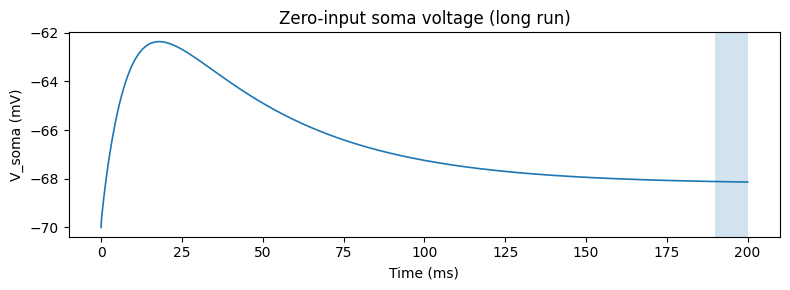

In [34]:
# =========================
# Zero-input drift test
# =========================

# 1) Run a long simulation with NO presynaptic input
t_test = 200.0  # ms (try 200; bump to 500 if needed)
pattern_zero = jnp.zeros((Nsyn,), dtype=jnp.float64)

def simulate_zero_long(params_phys, t_max_long=t_test):
    amps = base_amp * pattern_zero  # all zeros
    currents = jx.datapoint_to_step_currents(
        i_delay=1e9,          # put stimulus way outside the sim window
        i_dur=i_dur,
        i_amp=amps,           # all zero anyway
        delta_t=dt,
        t_max=t_max_long,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return np.asarray(traces)  # (Nsyn, T_long)

tr_long = simulate_zero_long(params_true, t_max_long=t_test)
t_long = np.arange(tr_long.shape[1]) * dt

# soma trace (recording 0)
v_soma = tr_long[0]

# 2) Quantify whether it "flattens": peak-to-peak in last 10 ms
last_ms = 10.0
mask_last = t_long >= (t_test - last_ms)
ptp_last = np.ptp(v_soma[mask_last])
mean_last = v_soma[mask_last].mean()

print("Zero-input long run")
print(f"  t_test = {t_test} ms, dt={dt} ms, T={tr_long.shape[1]}")
print(f"  soma mean in last {last_ms} ms: {mean_last:.3f} mV")
print(f"  soma peak-to-peak in last {last_ms} ms: {ptp_last:.6f} mV")

# 3) Plot soma (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(t_long, v_soma, lw=1.2)
plt.axvspan(t_test-last_ms, t_test, alpha=0.2)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Zero-input soma voltage (long run)")
plt.tight_layout()
plt.show()

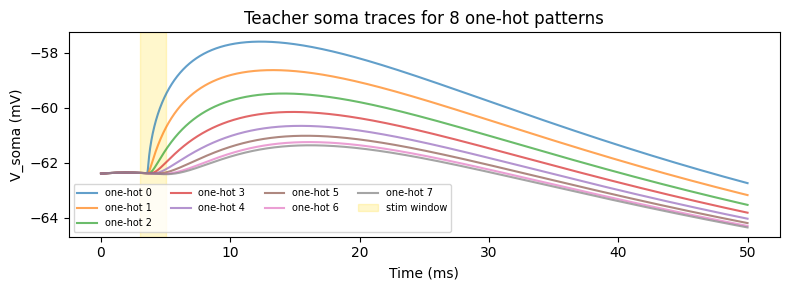

In [44]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

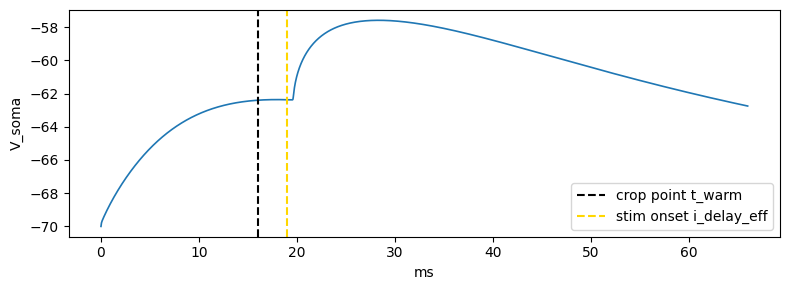

In [45]:
def simulate_full(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
                          data_stimuli=data_stimuli, delta_t=dt)
    return np.asarray(traces)  # (Nsyn, T_full)

# debug plot
tr_full = simulate_full(params_true, patterns_onehot[0])
t_full = np.arange(tr_full.shape[1]) * dt
plt.figure(figsize=(8,3))
plt.plot(t_full, tr_full[0], lw=1.2)
plt.axvline(t_warm, color="k", ls="--", label="crop point t_warm")
plt.axvline(i_delay_eff, color="gold", ls="--", label="stim onset i_delay_eff")
plt.legend(); plt.xlabel("ms"); plt.ylabel("V_soma"); plt.tight_layout(); plt.show()

In [136]:
# Make sure stimuli are cleared no matter what
net_analysis.delete_stimuli()

pattern_zero = jnp.zeros((Nsyn,), dtype=jnp.float64)

# IMPORTANT: call simulate_analysis directly (NOT batched_simulate_soma, NOT jit)
tr = simulate_analysis(params_true, pattern_zero)  # should use your current net state
v = np.asarray(tr[0])
t = np.arange(v.size) * dt

print("v(0) =", float(v[0]))
print("v(3ms) =", float(v[int(round(i_delay/dt))]))
print("ptp pre full:", float(np.ptp(v[t < i_delay])))
print("ptp pre last 0.5ms:", float(np.ptp(v[(t > i_delay-0.5) & (t < i_delay)])))

v(0) = -68.13569152122845
v(3ms) = -68.14124686358473
ptp pre full: 0.005510795242727795
ptp pre last 0.5ms: 0.0008067620214688986


In [104]:
import inspect

na = Na()
k  = K()
lk = Leak()

print("Na.init_state defined in:", na.init_state.__qualname__)
print("K.init_state defined in :", k.init_state.__qualname__)
print("Leak.init_state defined in:", lk.init_state.__qualname__)

print("\nNa.init_state source (first ~20 lines):")
print("\n".join(inspect.getsource(na.init_state).splitlines()[:25]))

Na.init_state defined in: Na.init_state
K.init_state defined in : K.init_state
Leak.init_state defined in: Leak.init_state

Na.init_state source (first ~20 lines):
    def init_state(self, states, v, params, delta_t):
        """Initialize the state such at fixed point of gate dynamics."""
        prefix = self._name
        alpha_m, beta_m = self.m_gate(v, params["vt"])
        alpha_h, beta_h = self.h_gate(v, params["vt"])
        return {
            f"{prefix}_m": alpha_m / (alpha_m + beta_m),
            f"{prefix}_h": alpha_h / (alpha_h + beta_h),
        }


In [105]:
net_analysis.set("v", -80.0)
net_analysis.init_states(delta_t=dt)
print(net_analysis.nodes.loc[:5, ["v","Na_m","Na_h","K_n"]])

net_analysis.set("v", -60.0)
net_analysis.init_states(delta_t=dt)
print(net_analysis.nodes.loc[:5, ["v","Na_m","Na_h","K_n"]])

      v      Na_m      Na_h       K_n
0 -80.0  0.000164  0.999975  0.000965
1 -80.0  0.000164  0.999975  0.000965
2 -80.0  0.000164  0.999975  0.000965
3 -80.0  0.000164  0.999975  0.000965
4 -80.0  0.000164  0.999975  0.000965
5 -80.0  0.000164  0.999975  0.000965
      v      Na_m      Na_h       K_n
0 -60.0  0.014757  0.995941  0.037697
1 -60.0  0.014757  0.995941  0.037697
2 -60.0  0.014757  0.995941  0.037697
3 -60.0  0.014757  0.995941  0.037697
4 -60.0  0.014757  0.995941  0.037697
5 -60.0  0.014757  0.995941  0.037697


In [106]:
tr_long = simulate_zero_long(params_true, t_max_long=200.0)  # your function
v_last = tr_long[:, -1]   # (Nsyn,)
print("recorded site voltages at end:", v_last)
print("range:", float(v_last.max() - v_last.min()), "mV")

recorded site voltages at end: [-68.13145704 -68.14425042 -68.15250079 -68.15654376 -68.15654376
 -68.15250079 -68.14425042 -68.13145704]
range: 0.025086712465565597 mV


In [ ]:
patterns_train = patterns_onehot # (8, 8) — identity matrix
targets_train = targets_onehot # (8, T) — teacher soma traces (see above!!)
N_train = patterns_train.shape[0]  # 8

print(f"Training set: {N_train} one-hot patterns × {Nsyn} synapses")
print(f"patterns_train shape: {patterns_train.shape}")
print(f"targets_train shape: {targets_train.shape}")
print(f"Target V range: [{float(targets_train.min()):.2f}, "
      f"{float(targets_train.max()):.2f}] mV")
print(f"\nPatterns (each row activates exactly 1 synapse):")
print(np.asarray(patterns_train))


Training set: 8 one-hot patterns × 8 synapses
patterns_train shape: (8, 8)
targets_train shape: (8, 2002)
Target V range: [-70.00, -57.62] mV

Patterns (each row activates exactly 1 synapse):
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
net_train = build_net()
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record() # soma only
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

def _sim_soma_train(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces[0] # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

train_lr = 0.05
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

checkpoints = [10, 25, 50, 75]
n_steps_train = max(checkpoints)  

def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=75, checkpoints=(10, 25, 50, 75), log_every=5):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    gS0 = jnp.clip(
        1e-4 * jnp.exp(0.15 * jax.random.normal(subkey, (Nsyn,))),
        1e-5, 1e-2,
    )
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    loss_log = []
    checkpoint_params = {}   
    ckpt_set = set(checkpoints)

    for step in range(1, n_steps + 1):
        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, patterns_train, targets_train,
        )

        if step % log_every == 0 or step == n_steps:
            loss_log.append((step, float(loss)))

        if step in ckpt_set:
            checkpoint_params[step] = train_transform.forward(opt_params)

    return checkpoint_params, {"losses": loss_log, "final_loss": float(loss)}


print(f"Sanity check: training seed=0 ({n_steps_train} steps, "
      f"checkpoints at {checkpoints})")
_t0 = _time.time()
_ckpt0, _log0 = train_one_seed(0, patterns_train, targets_train)
_t1 = _time.time()
print(f"Time: {_t1-_t0:.1f}s")
print(f"Init loss: {_log0['losses'][0][1]:.4f}")
print(f"Final loss:{_log0['final_loss']:.4f}")
for _c in sorted(_ckpt0):
    _gS_c = np.asarray(_ckpt0[_c][0]["IonotropicSynapse_gS"])
    print(f"gS @ step {_c:3d}: {_gS_c}  "
          f"(max |diff| from true = {np.abs(_gS_c - np.asarray(gS_true)).max():.2e})")


Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Sanity check: training seed=0 (75 steps, checkpoints at [10, 25, 50, 75]) ...
  Time: 64.6s
  Init loss:  0.1562
  Final loss: 0.0000
  gS @ step  10: [0.0001008  0.00010291 0.00010284 0.00010171 0.00010145 0.00010256
 0.0001044  0.00010671]  (max |diff| from true = 6.71e-06)
  gS @ step  25: [1.04755183e-04 9.71161906e-05 1.00712324e-04 1.02368646e-04
 1.02100300e-04 1.00901127e-04 9.96706187e-05 9.86307232e-05]  (max |diff| from true = 4.76e-06)
  gS @ step  50: [1.01201742e-04 1.00387105e-04 9.99157008e-05 9.96413291e-05
 9.96518755e-05 1.00038771e-04 1.00405745e-04 1.00528971e-04]  (max |diff| from true = 1.20e-06)
  gS @ step  75: [9.97829104e-05 1.00208625e-04 9.99788083e-05 9.99611907e-05
 1.00070764e-04 1.00022040e-04 9.98939433e-05 9.98497612e-05]  (max |diff| from true = 2.17e-07)


In [ ]:
S = 30

# added checkpoints
gS_ckpt = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
GRADS_ckpt = {c: np.zeros((S, Nsyn, Nsyn))    for c in checkpoints}  # (S,8,8)
VALL_ckpt = {c: np.zeros((S, Nsyn, Nsyn, T)) for c in checkpoints}  # (S,8,8,T)
LOSS_ckpt = {c: np.zeros((S, Nsyn))           for c in checkpoints}  # (S,8)
train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps  "
      f"(full-batch on {N_train} one-hots, lr={train_lr})")
print(f"Checkpoints: {checkpoints}")
print(f"Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,{T})  LOSS (S,8)\n")

t_start = _time.time()

for s in range(S):
    t_seed = _time.time()

    # ── Train ────────────────────────────────────────────────────────
    ckpt_params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_train,
        targets_train=targets_train,
    )
    train_logs_all.append(log_s)

    # ── Evaluate each checkpoint on 8 one-hot probes ─────────────────
    for c in checkpoints:
        params_c = ckpt_params_s[c]
        gS_ckpt[c][s] = np.asarray(params_c[0]["IonotropicSynapse_gS"])

        ((losses_c, traces_c), grads_c) = batched_vg(
            params_c, patterns_onehot, targets_onehot,
        )
        GRADS_ckpt[c][s] = np.asarray(grads_c[0]["IonotropicSynapse_gS"])  # (8,8)
        VALL_ckpt[c][s]  = np.asarray(traces_c)                            # (8,8,T)
        LOSS_ckpt[c][s]  = np.asarray(losses_c)                            # (8,)

    dt_seed = _time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        losses_str = "  ".join(
            f"step{c}={log_s['final_loss'] if c == checkpoints[-1] else float(LOSS_ckpt[c][s].mean()):.4f}"
            for c in checkpoints
        )
        print(f"  seed {s:3d}/{S}  {losses_str}  ({dt_seed:.1f}s)")

elapsed = _time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")

# ── Quick per-checkpoint summary ─────────────────────────────────────
print(f"\nPer-checkpoint probe loss (mean across seeds & patterns):")
for c in checkpoints:
    print(f"  step {c:3d}:  mean loss = {LOSS_ckpt[c].mean():.6f}  "
          f"  gS spread (std) = {gS_ckpt[c].std(axis=0).mean():.2e}")


Training 30 seeds × 75 steps  (full-batch on 8 one-hots, lr=0.05)
Checkpoints: [10, 25, 50, 75]
Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,2002)  LOSS (S,8)

  seed   0/30  step10=0.0428  step25=0.0124  step50=0.0009  step75=0.0000  (59.0s)
  seed   5/30  step10=0.0128  step25=0.0011  step50=0.0002  step75=0.0000  (59.0s)
  seed  10/30  step10=0.0025  step25=0.0073  step50=0.0006  step75=0.0000  (59.0s)
  seed  15/30  step10=0.0055  step25=0.0048  step50=0.0007  step75=0.0000  (59.0s)
  seed  20/30  step10=0.0282  step25=0.0035  step50=0.0017  step75=0.0000  (59.1s)
  seed  25/30  step10=0.0532  step25=0.0105  step50=0.0008  step75=0.0000  (59.1s)
  seed  29/30  step10=0.0184  step25=0.0049  step50=0.0003  step75=0.0000  (59.0s)

Done: 30 seeds in 1770.8s  (59.0s per seed)
Train final-loss range: [0.0000, 0.0003]

Per-checkpoint probe loss (mean across seeds & patterns):
  step  10:  mean loss = 0.048422    gS spread (std) = 5.09e-06
  step  25:  mean loss = 0.008854    gS spre

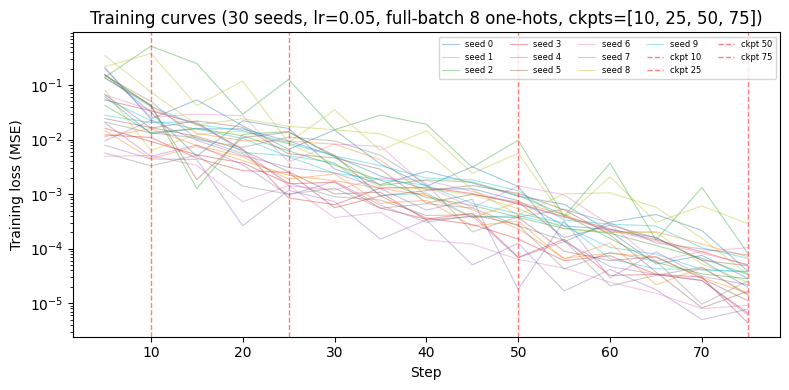

In [21]:
# training loss curves
fig, ax = plt.subplots(figsize=(8, 4))
for s_i, log_s in enumerate(train_logs_all):
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8,
            label=f"seed {s_i}" if s_i < 10 else None)

for c in checkpoints:
    ax.axvline(c, color="red", ls="--", lw=1, alpha=0.5,
               label=f"ckpt {c}" if c == checkpoints[0] else f"ckpt {c}")
ax.set_xlabel("Step"); ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves ({S} seeds, lr={train_lr}, "
             f"full-batch {N_train} one-hots, ckpts={checkpoints})")
ax.set_yscale("log")
ax.legend(fontsize=6, ncol=5)
plt.tight_layout(); plt.show()

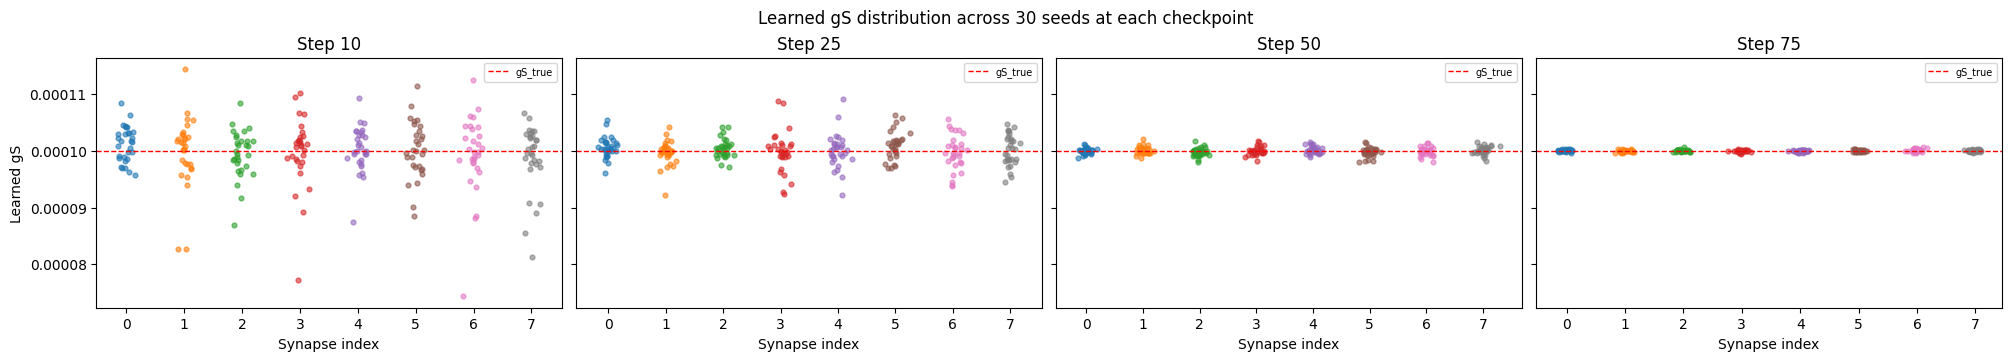

In [22]:
# learned gS at each checkpoint 
n_ckpt = len(checkpoints)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5 * n_ckpt, 3.5),
                         sharey=True, constrained_layout=True)
for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    for i in range(Nsyn):
        ax.scatter(np.full(S, i) + 0.08 * np.random.randn(S),
                   gS_ckpt[c][:, i], s=12, alpha=0.6)
    ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1, label="gS_true")
    ax.set_xlabel("Synapse index")
    if ci == 0:
        ax.set_ylabel("Learned gS")
    ax.set_title(f"Step {c}")
    ax.legend(fontsize=7)
fig.suptitle(f"Learned gS distribution across {S} seeds at each checkpoint",
             fontsize=12)
plt.show()

In [23]:
# pearson correlation again
def corr_over_seeds(X, y, eps=1e-12):
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

R_ckpt = {}   # {c: (8,8,8,T)}  -> R[p,i,j,t]
r_diag_ckpt = {}   # {c: (8,T)}  -> R[p,p,p,t]
r_off_ckpt = {}   # {c: (8,8,T)}  -> R[p,p,j,t] (includes diag too tho so just skip when not wanted!!!)

for c in checkpoints:
    Vraw = VALL_ckpt[c]  # (S,8,8,T)  
    G = GRADS_ckpt[c] # (S,8,8)

    R = np.zeros((Nsyn, Nsyn, Nsyn, T), dtype=np.float32)
    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = G[:, p, i]  # (S,)
            for j in range(Nsyn):
                R[p, i, j, :] = corr_over_seeds(Vraw[:, p, j, :], g_pi).astype(np.float32)

    R_ckpt[c] = R
    r_diag_ckpt[c] = R[np.arange(Nsyn), np.arange(Nsyn), np.arange(Nsyn), :]  # (8,T)
    r_off_ckpt[c]  = R[np.arange(Nsyn), np.arange(Nsyn), :, :] # (8,8,T)

okay this may be really wrong but if i plot the diagonals then we are asking soemthing like: at time t, across different trained networks (seeds), do the networks that have a larger gradient for synapse p (when only synapse p is stimulated) also show higher voltage at synapse site p?

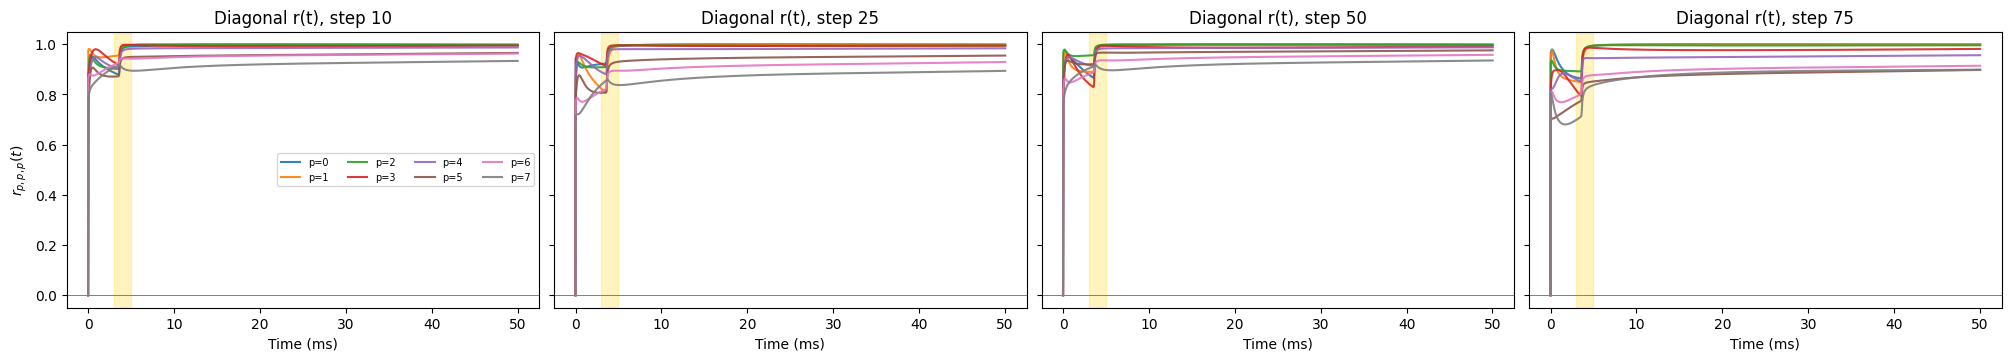

In [ ]:
# diagonal r(t)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5*n_ckpt, 3.5),
                         sharex=True, sharey=True, constrained_layout=True)

for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
    for p in range(Nsyn):
        ax.plot(t_arr, r_diag_ckpt[c][p], lw=1.5, alpha=0.9, label=f"p={p}")
    ax.axhline(0, color="grey", lw=0.7)
    ax.set_title(f"Diagonal r(t), step {c}")
    ax.set_xlabel("Time (ms)")
    if ci == 0:
        ax.set_ylabel(r"$r_{p,p,p}(t)$")
        ax.legend(fontsize=7, ncol=4)

plt.show()

When only synapse p is stimulated, and we look at the gradient for synapse p (i = p), which voltage recording site j (local synapse site vs other sites) best tracks that gradient across seeds, and when in time does it do so?

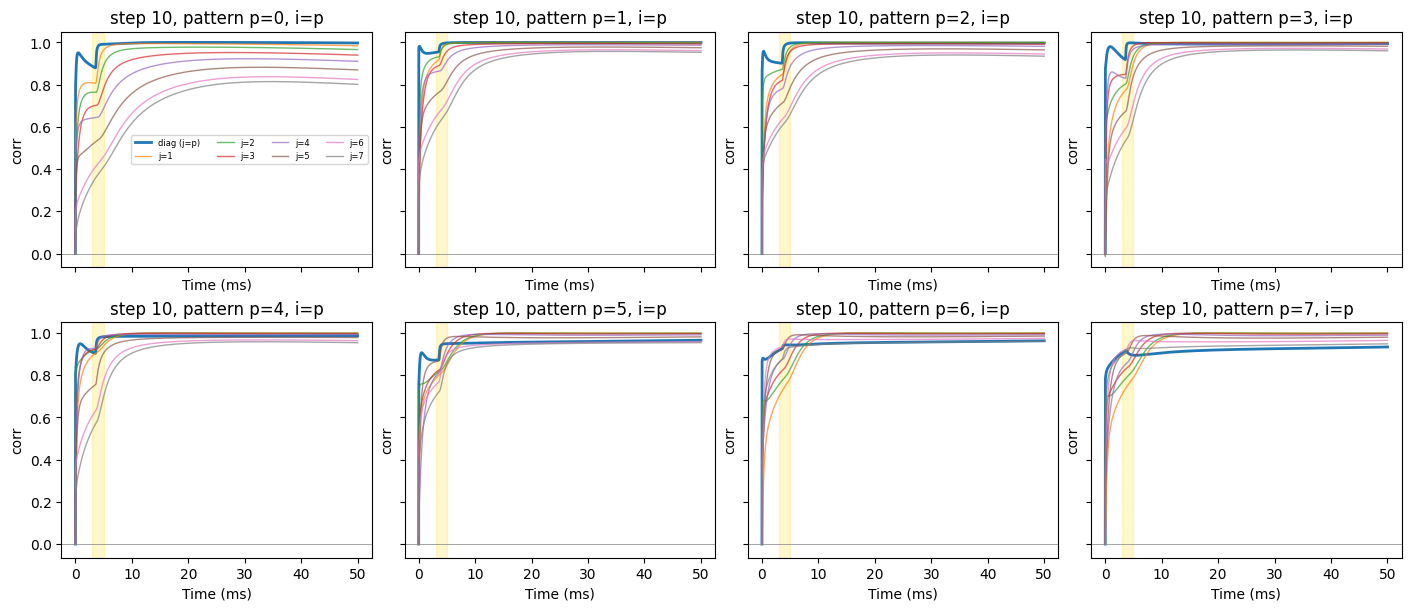

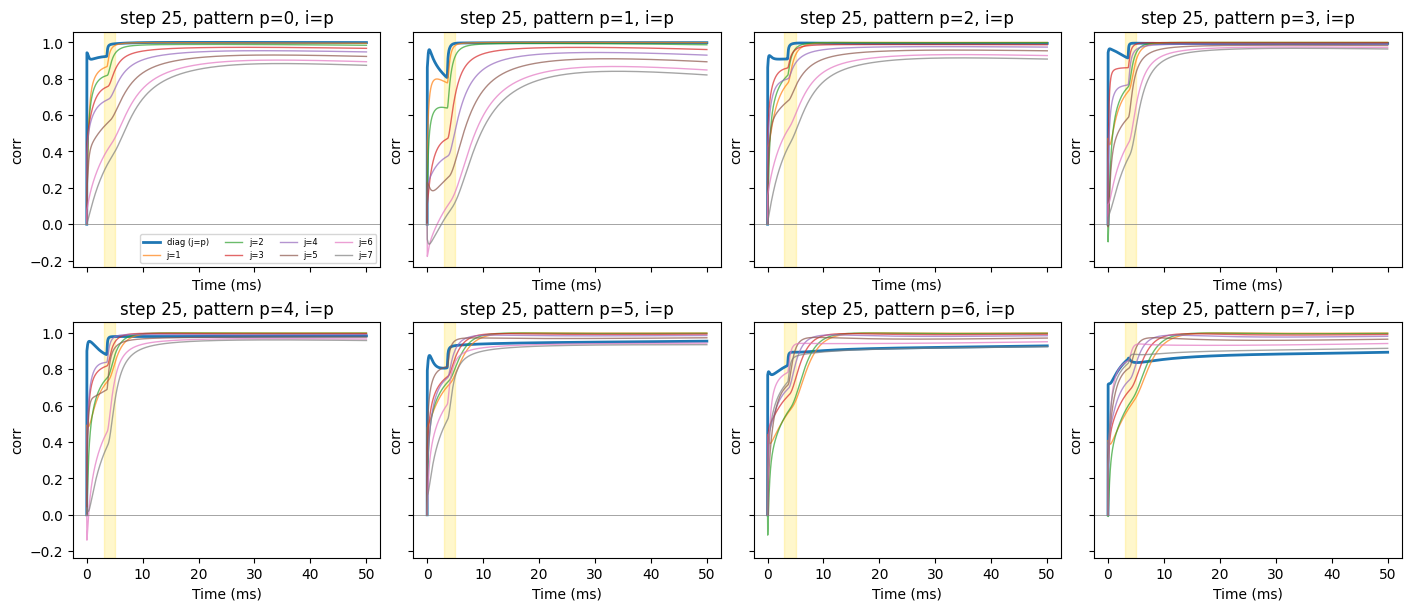

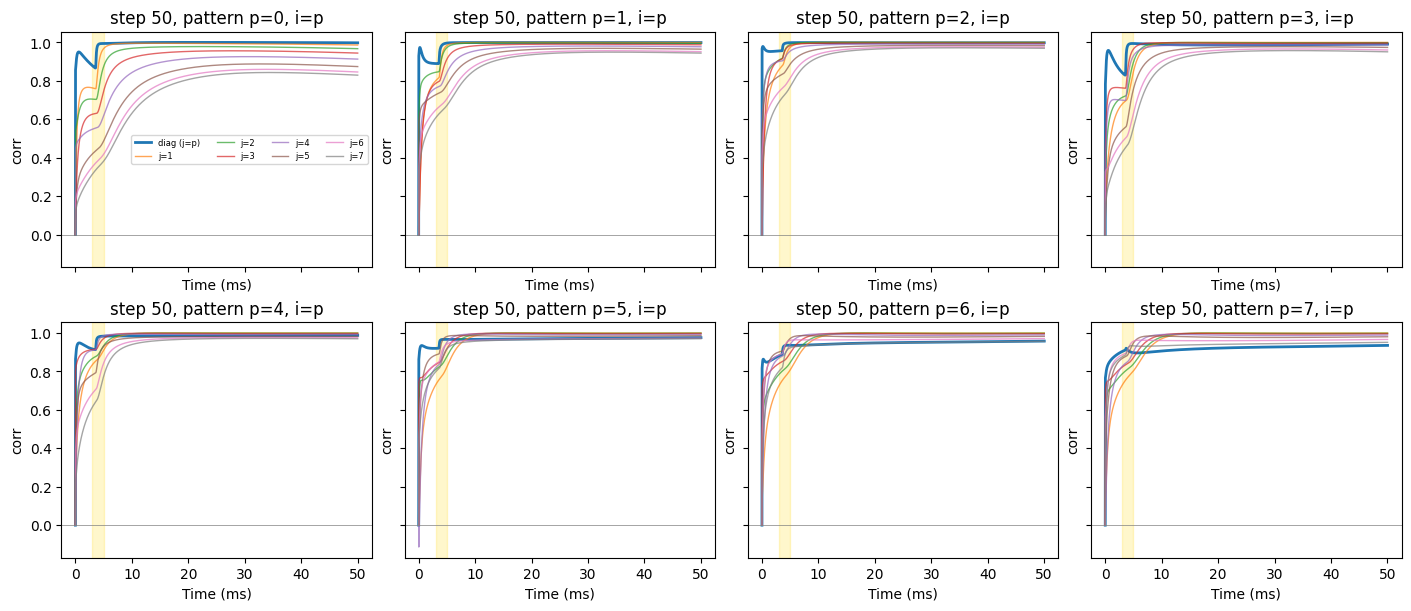

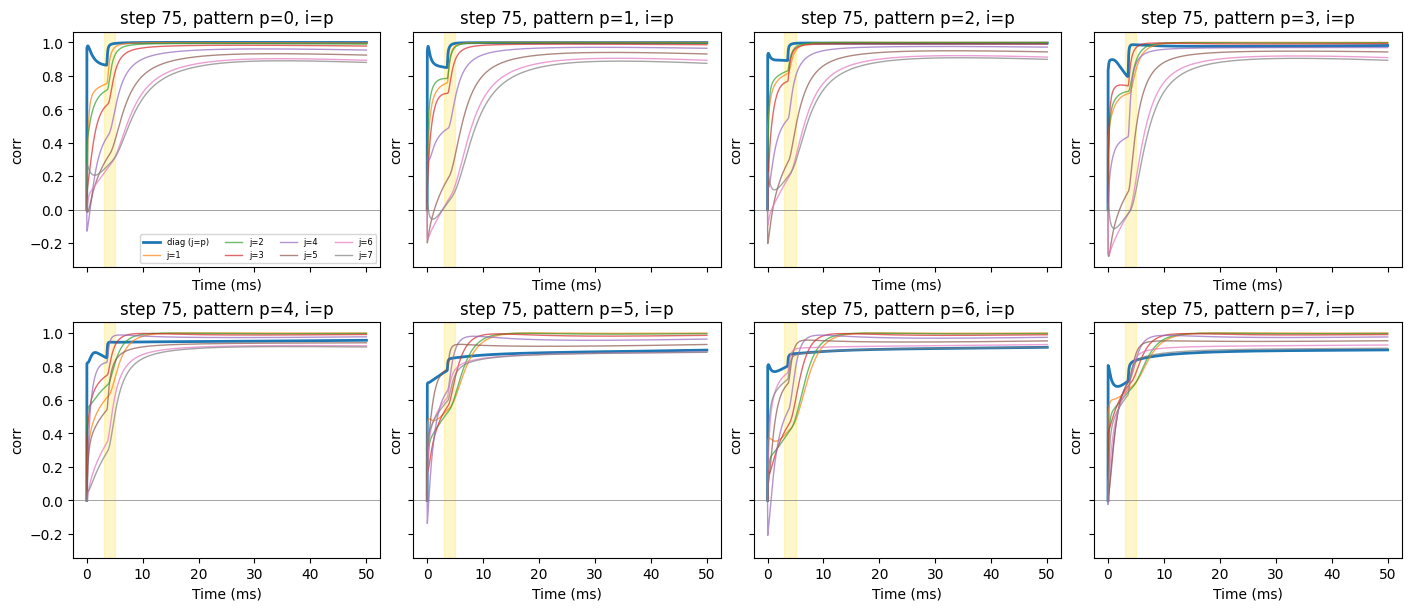

In [25]:
for c in checkpoints:
    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                             constrained_layout=True)
    axes = axes.ravel()
    for p in range(Nsyn):
        ax = axes[p]
        ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2)
        # diagonal in bold
        ax.plot(t_arr, r_off_ckpt[c][p, p], lw=2.0, label="diag (j=p)")
        # 7 off-diagonals
        for j in range(Nsyn):
            if j == p: 
                continue
            ax.plot(t_arr, r_off_ckpt[c][p, j], lw=1.0, alpha=0.7, label=f"j={j}")
        ax.axhline(0, color="grey", lw=0.5)
        ax.set_title(f"step {c}, pattern p={p}, i=p")
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("corr")
        if p == 0:
            ax.legend(fontsize=6, ncol=4)
    plt.show()

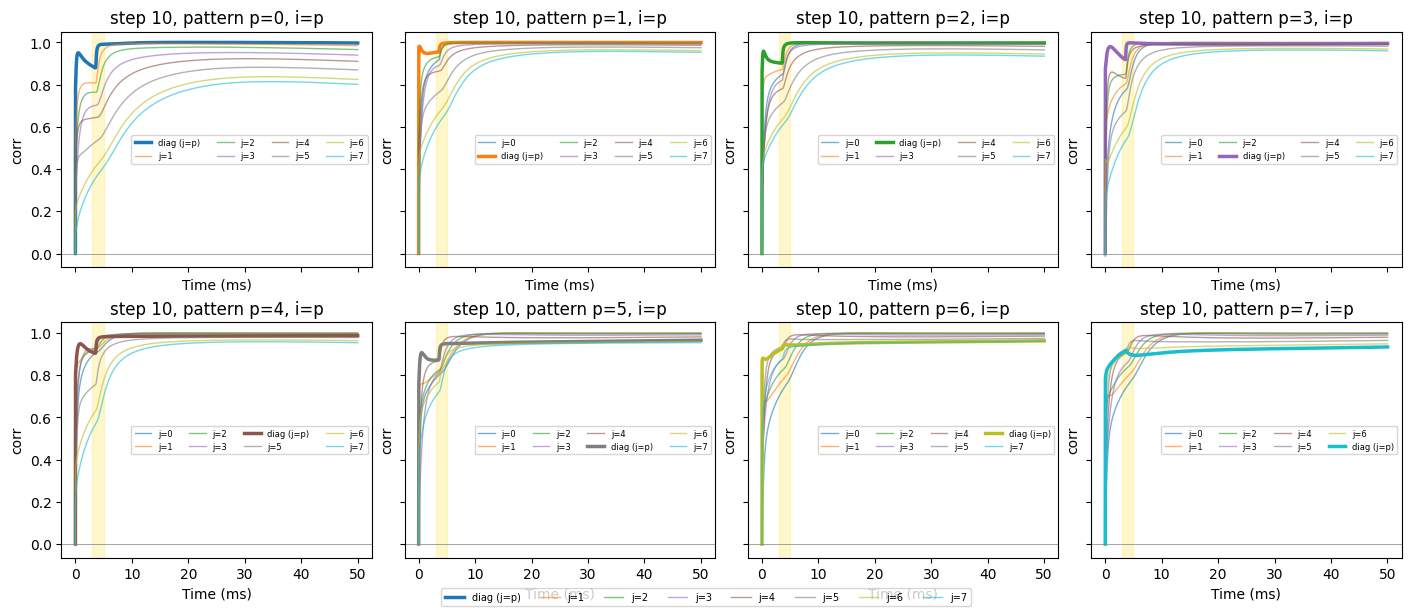

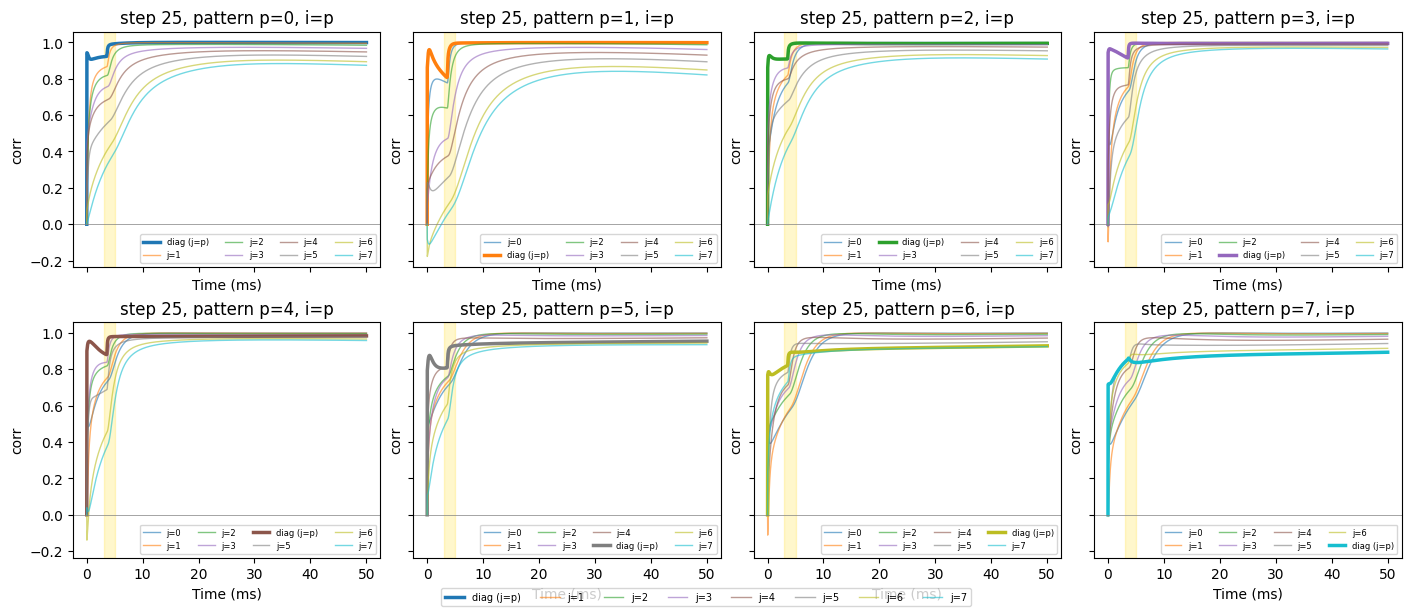

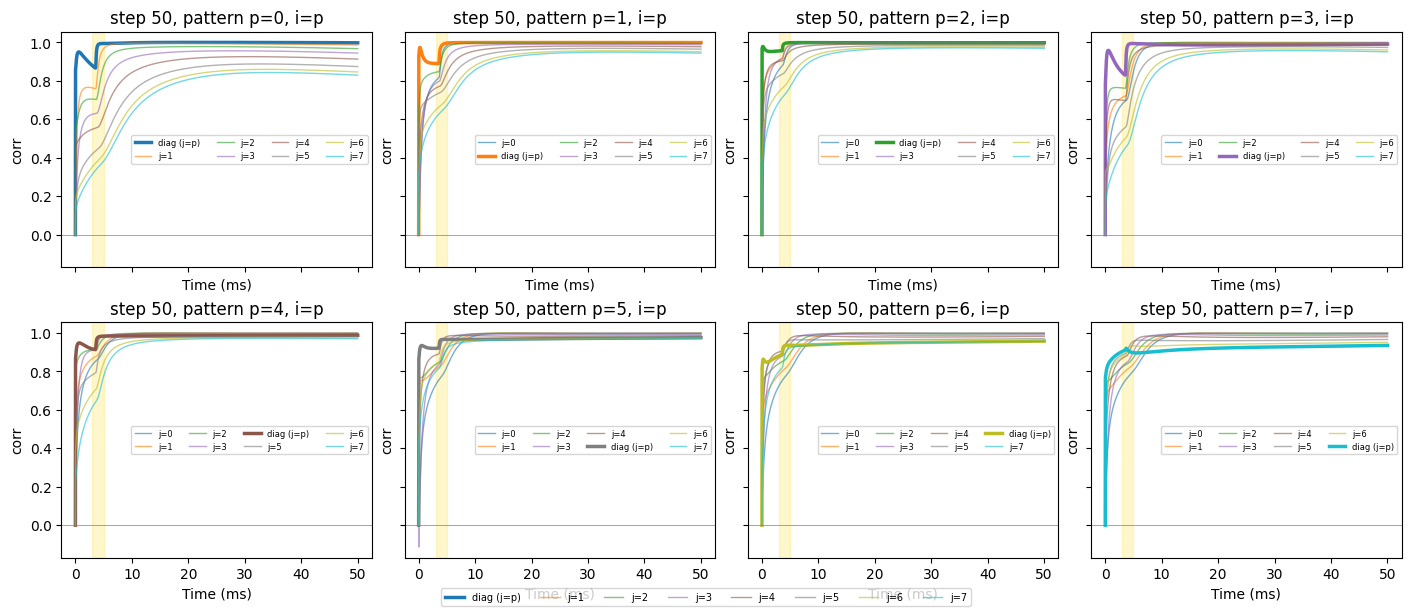

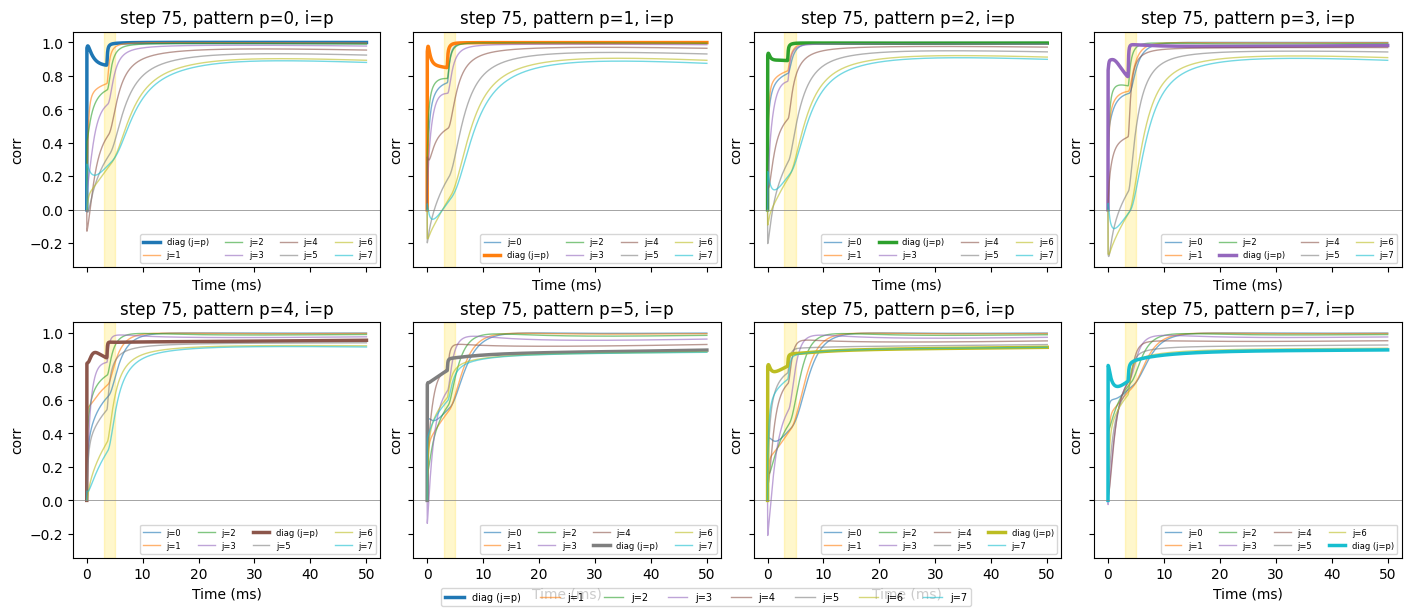

In [26]:
colors = plt.cm.tab10(np.linspace(0, 1, Nsyn))  # 8 distinct colors

for c in checkpoints:
    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                             constrained_layout=True)
    axes = axes.ravel()

    for p in range(Nsyn):
        ax = axes[p]
        ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2)

        # plot all sites j with fixed colors
        for j in range(Nsyn):
            lw = 2.5 if j == p else 1.0
            alpha = 1.0 if j == p else 0.6
            label = "diag (j=p)" if j == p else f"j={j}"
            ax.plot(t_arr, r_off_ckpt[c][p, j],
                    color=colors[j], lw=lw, alpha=alpha, label=label)

        ax.axhline(0, color="grey", lw=0.5)
        ax.set_title(f"step {c}, pattern p={p}, i=p")
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("corr")

        # optional: per-panel legend (small but correct)
        ax.legend(fontsize=6, ncol=4)

    # better: one global legend for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=9, fontsize=7)
    plt.show()
